In [1]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

from scipy.linalg import eigh, inv
from scipy.sparse import identity
from scipy import ndimage
from sklearn.cluster import KMeans

import utils
sys.path.append("..") # append parent path
import models.vision_transformer as vits

import glob
import json

root = 'vis_examples/' # 이미지 저장 위치
coco_annotations_file = '/home/shhan/oicr/data/coco/annotations/instances_val2014.json' # annotation path
coco_images_dir = "/home/shhan/oicr/data/coco/images/val2014" # data path

/home/shhan/.local/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (5.1.0)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(


In [2]:
from collections import defaultdict
import json
import numpy as np
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)
            
        self.annIm_dict = defaultdict(list)        
        self.cat_dict = {} 
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:           
            self.annIm_dict[ann['image_id']].append(ann) 
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]        
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [3]:
coco= COCOParser(coco_annotations_file, coco_images_dir)

In [4]:
coco.im_dict

{397133: {'license': 4,
  'file_name': '000000397133.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
  'height': 427,
  'width': 640,
  'date_captured': '2013-11-14 17:02:52',
  'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
  'id': 397133},
 37777: {'license': 1,
  'file_name': '000000037777.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000037777.jpg',
  'height': 230,
  'width': 352,
  'date_captured': '2013-11-14 20:55:31',
  'flickr_url': 'http://farm9.staticflickr.com/8429/7839199426_f6d48aa585_z.jpg',
  'id': 37777},
 252219: {'license': 4,
  'file_name': '000000252219.jpg',
  'coco_url': 'http://images.cocodataset.org/val2017/000000252219.jpg',
  'height': 428,
  'width': 640,
  'date_captured': '2013-11-14 22:32:02',
  'flickr_url': 'http://farm4.staticflickr.com/3446/3232237447_13d84bd0a1_z.jpg',
  'id': 252219},
 87038: {'license': 1,
  'file_name': '000000087038.jpg',
  'coco_url': 'http://images.

In [9]:
parser = argparse.ArgumentParser('Visualize Self-Attention maps')
parser.add_argument('--arch', default='vit_small', type=str,
    choices=['vit_tiny', 'vit_small', 'vit_base'], help='Architecture (support only ViT atm).')
parser.add_argument('--patch_size', default=8, type=int, help='Patch resolution of the model.')
parser.add_argument('--pretrained_weights', default='', type=str,
    help="Path to pretrained weights to load.")
parser.add_argument("--checkpoint_key", default="teacher", type=str,
    help='Key to use in the checkpoint (example: "teacher")')
parser.add_argument("--image_path", default=None, type=str, help="Path of the image to load.")
parser.add_argument("--image_size", default=(480, 480), type=int, nargs="+", help="Resize image.")
parser.add_argument('--output_dir', default='.', help='Path where to save visualizations.')
parser.add_argument("--threshold", type=float, default=None, help="""We visualize masks
    obtained by thresholding the self-attention maps to keep xx% of the mass.""")
args = parser.parse_args(args=[])

args.arch = 'vit_small' # model type
args.patch_size = 8 # patch size
args.image_size = (640, 640) # input image size
args.pretrained_weights = 'small_8patch.pth' # checkpoint path


In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# build model
model = vits.__dict__[args.arch](patch_size=args.patch_size, num_classes=0)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)
if os.path.isfile(args.pretrained_weights):
    state_dict = torch.load(args.pretrained_weights, map_location="cpu")
    if args.checkpoint_key is not None and args.checkpoint_key in state_dict:
        print(f"Take key {args.checkpoint_key} in provided checkpoint dict")
        state_dict = state_dict[args.checkpoint_key]
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
    print('Pretrained weights found at {} and loaded with msg: {}'.format(args.pretrained_weights, msg))
else:
    print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
    url = None
    if args.arch == "vit_small" and args.patch_size == 16:
        url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
    elif args.arch == "vit_small" and args.patch_size == 8:
        url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"  # model used for visualizations in our paper
    elif args.arch == "vit_base" and args.patch_size == 16:
        url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
    elif args.arch == "vit_base" and args.patch_size == 8:
        url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
    if url is not None:
        print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
        state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
        model.load_state_dict(state_dict, strict=True)
    else:
        print("There is no reference weights available for this model => We use random weights.")


Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


In [11]:
coco.im_dict.items()

dict_items([(397133, {'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}), (37777, {'license': 1, 'file_name': '000000037777.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000037777.jpg', 'height': 230, 'width': 352, 'date_captured': '2013-11-14 20:55:31', 'flickr_url': 'http://farm9.staticflickr.com/8429/7839199426_f6d48aa585_z.jpg', 'id': 37777}), (252219, {'license': 4, 'file_name': '000000252219.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000252219.jpg', 'height': 428, 'width': 640, 'date_captured': '2013-11-14 22:32:02', 'flickr_url': 'http://farm4.staticflickr.com/3446/3232237447_13d84bd0a1_z.jpg', 'id': 252219}), (87038, {'license': 1, 'file_name': '000000087038.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/0000000

In [12]:
coco_images_dir

'/home/shhan/oicr/data/coco/images/val2017'

In [13]:
img_path = []
ids = []
for id, annotations in coco.im_dict.items():
    img = annotations['file_name']
    img_path.append(coco_images_dir + '/' + img)
    ids.append(id)


In [14]:
img_path

['/home/shhan/oicr/data/coco/images/val2017/000000397133.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000037777.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000252219.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000087038.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000174482.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000403385.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000006818.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000480985.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000458054.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000331352.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000296649.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000386912.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000502136.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000491497.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/000000184791.jpg',
 '/home/shhan/oicr/data/coco/images/val2017/00000034888

In [24]:
def ncut(feats, patch_num, tau = 0.2, eps=1e-5, no_binary_graph=False, flip=False, force_flip=False):
     # cls_token = feats[0,0:1,:].cpu().numpy() 
    A = feats.cpu().numpy() # attention map, [196, 196]
    N = A.shape[0]
    # A = A > tau # [196 196]
    # A = np.where(A.astype(float) == 0, eps, A) # 0->epsilon, else same
    A = np.where(A.astype(float) <= tau, eps, A) # 0->epsilon, else same
    d_i = np.sum(A, axis=1) # [196 1] -> [196]
    D = np.diag(d_i) # [196 196] to diagonal, ex. [a b c] -> [a 0 0] [0 b 0] [0 0 c]
    
    laplacian = D - A
    # laplacian = identity(N).toarray() - (inv(D) @ A)
    # Print second and third smallest eigenvector 
    eigenvalues, eigenvectors = eigh(laplacian, D, subset_by_index=[1,num_eig])
    #print(eigenvectors.shape)

    # Using average point to compute bipartition 
    second_smallest_vec = eigenvectors[:, 0] # [M]
    avg = np.sum(second_smallest_vec) / len(second_smallest_vec)
    #avg = 0
    # print(f'Average is {avg}')
    bipartition = second_smallest_vec > avg # [M]
    bipartition = bipartition.reshape(*patch_num).astype(float) # [14, 14]
    
    return bipartition, second_smallest_vec, eigenvectors

def NormalizeTensor(data):
    return (data - torch.min(data)) / (torch.max(data) - torch.min(data))

def bwlabel(clustered, conn): # clustered (torch)
    from scipy.ndimage import label
    
    if (conn != 4) and (conn !=8):
        print("Incorrect connectivity. Can only be 4 or 8")
        return -1
    if conn == 8:
        structure = [[0,1,0],
                    [1,1,0],
                    [0,0,0]]
    
    clustered = np.array(clustered) # torch -> numpy
    [x,y] = clustered.shape 
    clusters = np.unique(clustered) # the total types of clusters

    tot_labels = []
    for c in clusters:
        mask = np.array(clustered==c, dtype=bool)
        mask = mask.astype(np.int32) # 0 or 1

        if conn == 4:
            labeled_array, num_features = label(mask)
        elif conn == 8: 
            labeled_array, num_features = label(mask, structure=structure)

        tot_labels.append(labeled_array)        

    return tot_labels

def get_bbox(tot_labels, c, mask_attn):
    bboxes = []
    tot_bboxes = 0
    mask_attn = mask_attn.cpu()
    bbox = np.unique(tot_labels[c])

    for i in bbox[1:]:
        idx = np.where(tot_labels[c]==i)

        if np.mean([mask_attn[idx[0][i],idx[1][i]] for i in range(len(idx[0]))]) < 0.1:
            continue
        x1 = np.min(idx[0]); x2 = np.max(idx[0])
        y1 = np.min(idx[1]); y2 = np.max(idx[1])

        if (((x2-x1) > 1) or ((y2-y1) > 1)) and not (y1==0 and x1==0):
            bboxes.append([x1, y1, x2-x1, y2-y1]) # x, y, w, h
            tot_bboxes +=1

    return bboxes

/home/shhan/oicr/data/coco/images/val2017/000000087038.jpg


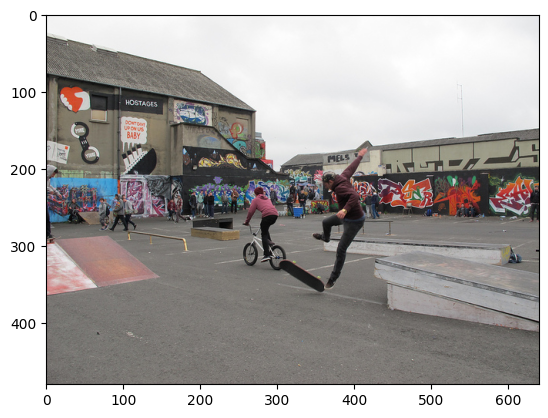

In [25]:
im = img_path[3]
print(im)

with open(im, 'rb') as f:
    orig_img = Image.open(f)
    orig_img = orig_img.convert('RGB')

plt.imshow(orig_img)

In [27]:
import pickle
transform = pth_transforms.Compose([
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

proposals = {}
for i in range(len(img_path)):
    im = img_path[i]
    with open(im, 'rb') as f:
        orig_img = Image.open(f)
        orig_img = orig_img.convert('RGB')
    
    img = transform(orig_img)
    w, h = img.shape[1] - img.shape[1] % args.patch_size, img.shape[2] - img.shape[2] % args.patch_size
    img = img[:, :w, :h].unsqueeze(0)
    w_featmap = img.shape[-2] // args.patch_size
    h_featmap = img.shape[-1] // args.patch_size

    attentions, _x_ctxed, _x_final = model.get_last_selfattention(img.to(device)) # 1 head 1+tokens 1+tokens

    cls_attn = attentions.mean(1).squeeze()[0,1:].reshape(w_featmap, h_featmap)
    num_eig = 5 # 사용할 eigenvector 개수

    x_ctxed = _x_ctxed.squeeze()[1:, :] # N D
    x_ctxed = F.normalize(x_ctxed,p=2)
    x_ctxed_aff = x_ctxed @ x_ctxed.transpose(1,0) # N N
    affinity_mat = x_ctxed_aff.clone()
    attn = x_ctxed_aff.sum(dim=-1) # N

    attn_norm_min = attn.min()
    if attn_norm_min < 0:
        attn = attn - attn_norm_min + 1e-10
    # attn /= attn.squeeze().sum()
    attn = attn.reshape(w_featmap, h_featmap)

    mask, eigenvec, full_eigen = ncut(affinity_mat, (w_featmap, h_featmap), tau = 0.2)
    eigenvec_sorted = np.sort(eigenvec)
    x_val = list(range(int(eigenvec.shape[0])))

    mask_attn = 0.8*NormalizeTensor(cls_attn)+0.2*NormalizeTensor(attn)
    tot_bboxes = np.empty((1,4))
    
    for k in [2,5,10]: # kmeans 개수
        kmeans = KMeans(n_clusters=k, random_state=5)
        kmeans.fit(full_eigen)
        result = kmeans.fit_predict(full_eigen)
        scaled = result / k
        clustered = torch.tensor(scaled).reshape(w_featmap, h_featmap)  
        
        tot_labels = bwlabel(clustered, 4)

        for c in range(k):
            if len(get_bbox(tot_labels, c, mask_attn)) == 0:
                continue
            tot_bboxes = np.concatenate((tot_bboxes, get_bbox(tot_labels, c, mask_attn)),axis=0)

    tot_bboxes = tot_bboxes[1:] # get rid of empty bbox
    proposals[ids[i]] = tot_bboxes

    if i % 10 == 0:
        with open('../data/coco_val2017_proposals.pkl', 'wb') as f:
            pickle.dump(proposals, f, pickle.HIGHEST_PROTOCOL)
        print("../data/coco_val2017_proposals.pkl saved")

../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val2017_proposals.pkl saved
../data/coco_val

In [ ]:
os.getcwd()

'/home/shhan/oicr/tools'

In [ ]:
import pickle

# save
with open('/data/coco_val2017_proposals.pkl', 'wb') as f:
    pickle.dump(proposals, f, pickle.HIGHEST_PROTOCOL)

# load
with open('/data/coco_val2017_proposals.pkl', 'rb') as f:
    data = pickle.load(f)

In [114]:
proposals[ids[3]].shape

(173, 4)

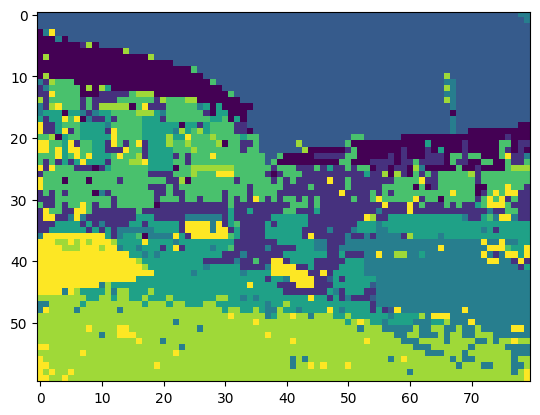

In [72]:
plt.imshow(clustered)

In [109]:
#from torchvision.ops import complete_box_iou_loss as box_iou
from torchvision.ops.boxes import box_iou
def nms(bboxes: torch.Tensor, scores: torch.Tensor, iou_threshold: float):
    order = torch.argsort(-scores)
    indices = torch.arange(bboxes.shape[0])
    keep = torch.ones_like(indices, dtype=torch.bool)
    for i in indices:
        if keep[i]:
            bbox = bboxes[order[i]]
            iou = box_iou(bbox[None,...],(bboxes[order[i + 1:]]) * keep[i + 1:][...,None])
            overlapped = torch.nonzero(iou > iou_threshold)
            keep[overlapped + i + 1] = 0
    return order[keep]

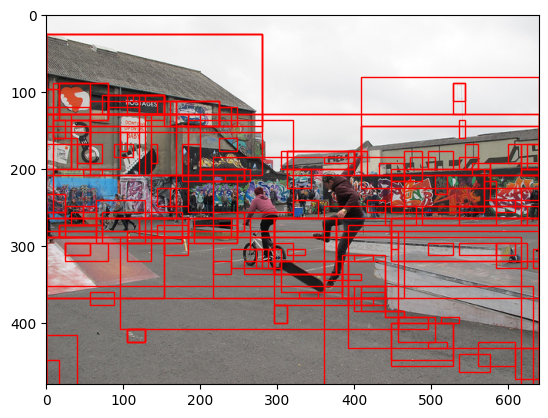

In [117]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(orig_img)

tot_bboxes = proposals[ids[3]]
tot_bboxes = np.array(tot_bboxes, dtype=np.int32)


for i in range(len(tot_bboxes)):
    [x1, y1, w, h] = tot_bboxes[i]
    rect = patches.Rectangle((y1*8, x1*8), (h+1)*8, (w+1)*8, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

/home/shhan/anaconda3/envs/oicr/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shhan/anaconda3/envs/oicr/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


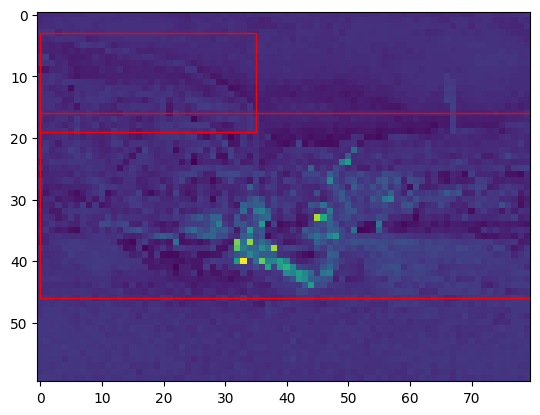

In [118]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(mask_attn.cpu())

mask_attn = mask_attn.cpu()

tot_bboxes = proposals[ids[3]]
tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
cls_scores = np.array([np.mean(np.array(mask_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1])) for bbox in tot_bboxes])
idx = np.where(np.array(cls_scores) > 0)[0]
bboxes = tot_bboxes[idx]
scores = cls_scores[idx]
selected = nms(torch.Tensor(bboxes), torch.Tensor(scores), iou_threshold=0.06)
for i in selected:
    [x1, y1, w, h] = bboxes[i]
    rect = patches.Rectangle((y1, x1), (h+1), (w+1), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

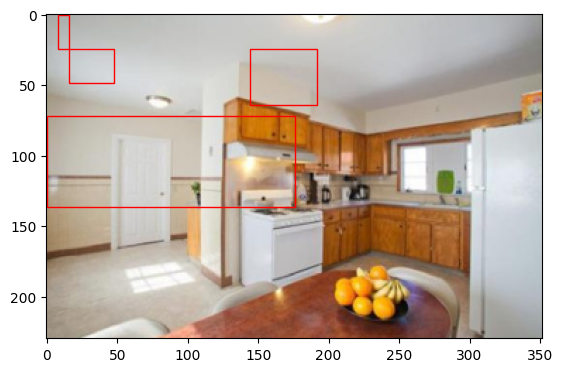

In [63]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
ax.imshow(orig_img)

tot_bboxes = proposals[ids[1]]
tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
cls_scores = np.array([np.mean(np.array(mask_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1])) for bbox in tot_bboxes])
idx = np.where(np.array(cls_scores) > 0.15)[0]
bboxes = tot_bboxes[idx]
scores = cls_scores[idx]
selected = nms(torch.Tensor(bboxes), torch.Tensor(scores), iou_threshold=0.06)
for i in selected:
    [x1, y1, x2, y2] = bboxes[i]
    rect = patches.Rectangle((y1*8, x1*8), (y2-y1+1)*8, (x2-x1+1)*8, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()